In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import copy
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from typhon import plots

import konrad


/home/mpim/m300733/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/mpim/m300733/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


2019-07-29 09:38:03 MainProcess:INFO:root:Created Konrad object:
RCE(
    atmosphere=Atmosphere,
    radiation=RRTMG,
    ozone=OzonePressure,
    humidity=FixedRH,
    surface=SurfaceFixedTemperature,
    cloud=<konrad.cloud.ClearSky object at 0x7f51f7a38198>,
    convection=HardAdjustment,
    lapserate=MoistLapseRate,
    upwelling=StratosphericUpwelling,
    aerosol=<konrad.aerosol.NoAerosol object at 0x7f51f7a38080>,
    max_duration=6000.0,
    timestep=0.6666666666666666,
    writeevery=200,
    max_iterations=9000.0,
    niter=0,
    delta=0.0001,
    deltaT=None,
    converged=False,
    outfile=/scratch/local1/m300733/convergence9.nc,
    nchandler=None,
    experiment=RCE,
)
2019-07-29 09:38:03 MainProcess:INFO:konrad.core:Start RCE model run.
2019-07-29 09:38:03 MainProcess:INFO:konrad.core:Enter iteration 0.
2019-07-29 09:38:06 MainProcess:INFO:konrad.core:Enter iteration 100.
2019-07-29 09:38:09 MainProcess:INFO:konrad.core:Enter iteration 200.
2019-07-29 09:38:11 MainPro

2019-07-29 09:41:57 MainProcess:INFO:konrad.core:Converged after 217 iterations.


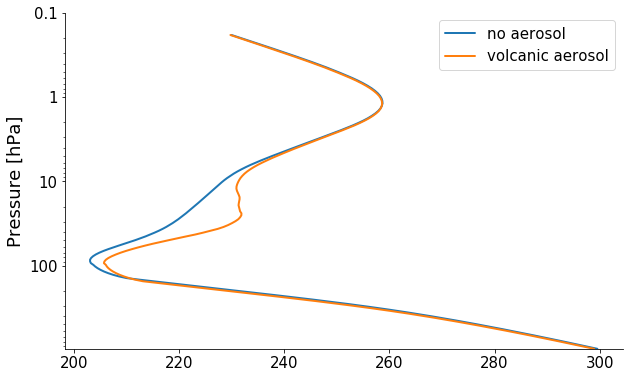

In [3]:
#fixed surface temperature run
plev, phlev = konrad.utils.get_pressure_grids(1000e2, 1, 201)
atmosphere = konrad.atmosphere.Atmosphere(plev)
solarConstant=480
Albedo=0.2
fixedRH=0.4
pressureLimitIndex=165
maxDuration='6000d'
maxDuration2='300d'
upwellingVelocity=0
year=1991
pressureMin=10
zenith_angle =42.05
run=str(9)
fixedWater=0
 
convergenceFile='convergence'+run+'.nc'
convergenceFileAerosol='convergenceAerosol'+run+'.nc'
convergenceInputPath='/scratch/local1/m300733/'+convergenceFile
convergenceInputPathAerosol='/scratch/local1/m300733/'+convergenceFileAerosol
stratospheric_upwelling = konrad.upwelling.StratosphericUpwelling(w=upwellingVelocity)

# Load a standard atmosphere.
#atmosphere = konrad.atmosphere.Atmosphere.from_netcdf(
#    ncfile='data/tropical-standard.nc',
#)
atmosphere.tracegases_rcemip()  # Atmosphere composition according to RCEMIP.

# Plot the initial temperature profile (for comparison).
plt.style.use(plots.styles('typhon'))
fig, ax = plt.subplots()
#plots.profile_p_log(atmosphere['plev'], atmosphere['T'][-1, :], label='Initial state')
atmosphere.tracegases_rcemip()  # Atmosphere composition according to RCEMIP.
# Initialize the setup for the radiative-convective equilibrium simulation.
rce = konrad.RCE(
    atmosphere,
    #surface=surface,
    radiation=konrad.radiation.RRTMG(solar_constant=solarConstant,zenith_angle =zenith_angle),  # Use RRTMG radiation scheme.
    #surface=konrad.surface.SurfaceHeatCapacity(albedo=Albedo),
    surface=konrad.surface.SurfaceFixedTemperature(albedo=0.2, temperature=300.0, longwave_emissivity=1, height=0.0),
    convection=konrad.convection.HardAdjustment(),  # Perform a hard convective adjustment.
    #convection=konrad.convection.RelaxedAdjustment(),
    lapserate=konrad.lapserate.MoistLapseRate(),  # Adjust towards a moist adiabat.
    timestep='16h',  # Set timestep in model time.
    #humidity=konrad.humidity.FixedRH(rh_func=konrad.humidity.FixedUTH()),
    humidity=konrad.humidity.FixedRH(rh_func=konrad.humidity.HeightConstant(rh_surface=fixedRH)), 
    upwelling=stratospheric_upwelling,
    max_duration=maxDuration,  # Set maximum runtime.
    aerosol=konrad.aerosol.NoAerosol(),
    outfile=convergenceInputPath ,
    writeevery=200,
)
rce.run()  # Start the simulation.
# Plot the equilibrium temperature profile.
noAerosolAtm=atmosphere.copy()
equiNoAeroInput1=atmosphere.copy()
equiNoAeroInput2=atmosphere.copy()
plots.profile_p_log(atmosphere['plev'][0:pressureLimitIndex], atmosphere['T'][-1, 0:pressureLimitIndex], label='no aerosol')
ax = plt.gca()
ax.set_ylim([pressureMin,max(atmosphere['plev'])])
plt.gca().invert_yaxis()
ax.legend()
#plev, phlev = konrad.utils.get_pressure_grids(1000e2, 1, 201)
#atmosphere = konrad.atmosphere.Atmosphere(plev)
# Initialize the setup for the radiative-convective equilibrium simulation.
rce = konrad.RCE(
    equiNoAeroInput1,
    #surface=konrad.surface.SurfaceHeatCapacity(albedo=Albedo),
    surface=konrad.surface.SurfaceFixedTemperature(albedo=0.2, temperature=299.4, longwave_emissivity=1, height=0.0),
    radiation=konrad.radiation.RRTMG(solar_constant=solarConstant,zenith_angle =zenith_angle),  # Use RRTMG radiation scheme.
    convection=konrad.convection.HardAdjustment(),  # Perform a hard convective adjustment.
    #convection=konrad.convection.RelaxedAdjustment(),
    lapserate=konrad.lapserate.MoistLapseRate(),  # Adjust towards a moist adiabat.
    timestep='16h',  # Set timestep in model time.
    #humidity=konrad.humidity.FixedRH(rh_func=konrad.humidity.FixedUTH()),
    humidity=konrad.humidity.FixedRH(rh_func=konrad.humidity.HeightConstant(rh_surface=fixedRH)),
    max_duration=maxDuration2,  # Set maximum runtime.
    aerosol=konrad.aerosol.VolcanoAerosol(),
    upwelling=stratospheric_upwelling,
    outfile=convergenceInputPathAerosol,
    writeevery=1,
)
rce.run()  # Start the simulation.

# Plot the equilibrium temperature profile.
AerosolAtm=equiNoAeroInput1.copy()
plots.profile_p_log(equiNoAeroInput1['plev'][0:pressureLimitIndex], equiNoAeroInput1['T'][-1, 0:pressureLimitIndex], label='volcanic aerosol')
ax = plt.gca()
ax.set_ylim([pressureMin,max(atmosphere['plev'])])
plt.gca().invert_yaxis()
ax.legend()
if fixedWater:
    rce = konrad.RCE(
        equiNoAeroInput2,
        surface=konrad.surface.SurfaceHeatCapacity(albedo=Albedo),
        radiation=konrad.radiation.RRTMG(solar_constant=solarConstant,zenith_angle =zenith_angle),  # Use RRTMG radiation scheme.
        convection=konrad.convection.HardAdjustment(),  # Perform a hard convective adjustment.
        lapserate=konrad.lapserate.MoistLapseRate(),  # Adjust towards a moist adiabat.
        timestep='16h',  # Set timestep in model time.
        humidity=konrad.humidity.FixedVMR(),
        max_duration=maxDuration2,  # Set maximum runtime.
        aerosol=konrad.aerosol.VolcanoAerosol(),
        outfile=convergenceInputPathAerosol,
        upwelling=stratospheric_upwelling,
        writeevery=200,
    )
    rce.run()  # Start the simulation.

# Plot the equilibrium temperature profile.
    AerosolAtmFixWV=equiNoAeroInput2.copy()
    plots.profile_p_log(equiNoAeroInput2['plev'][0:pressureLimitIndex], equiNoAeroInput2['T'][-1, 0:pressureLimitIndex], label='volcanic aerosol fixed WV')

ax = plt.gca()
ax.set_ylim([pressureMin,max(atmosphere['plev'])])
plt.gca().invert_yaxis()
ax.legend()

#plev, phlev = konrad.utils.get_pressure_grids(1000e2, 1, 201)
#atmosphere = konrad.atmosphere.Atmosphere(plev)

In [1]:
#clouds run
plev, phlev = konrad.utils.get_pressure_grids(1000e2, 1, 201)
atmosphere = konrad.atmosphere.Atmosphere(plev)
solarConstant=500
Albedo=0.2
fixedRH=0.4
pressureLimitIndex=165
maxDuration='6000d'
maxDuration2='300d'
upwellingVelocity=0
year=1991
pressureMin=10
zenith_angle =42.05
run=str(9)
fixedWater=0
cloudy_cloud = konrad.cloud.DirectInputCloud(numlevels=200, 
                cloud_fraction=0.1, lw_optical_thickness=0.09,sw_optical_thickness=0.04)
rt = konrad.radiation.RRTMG(mcica=True, solar_constant=solarConstant,zenith_angle =zenith_angle)
convergenceFile='convergence'+run+'.nc'
convergenceFileAerosol='convergenceAerosol'+run+'.nc'
convergenceInputPath='/scratch/local1/m300733/'+convergenceFile
convergenceInputPathAerosol='/scratch/local1/m300733/'+convergenceFileAerosol
stratospheric_upwelling = konrad.upwelling.StratosphericUpwelling(w=upwellingVelocity)

# Load a standard atmosphere.
#atmosphere = konrad.atmosphere.Atmosphere.from_netcdf(
#    ncfile='data/tropical-standard.nc',
#)
atmosphere.tracegases_rcemip()  # Atmosphere composition according to RCEMIP.

# Plot the initial temperature profile (for comparison).
plt.style.use(plots.styles('typhon'))
fig, ax = plt.subplots()
#plots.profile_p_log(atmosphere['plev'], atmosphere['T'][-1, :], label='Initial state')
atmosphere.tracegases_rcemip()  # Atmosphere composition according to RCEMIP.
# Initialize the setup for the radiative-convective equilibrium simulation.
rce = konrad.RCE(
    atmosphere,
    #surface=surface,
    cloud=cloudy_cloud, 
    radiation=rt,
    #radiation=konrad.radiation.RRTMG(solar_constant=solarConstant,zenith_angle =zenith_angle),  # Use RRTMG radiation scheme.
    #surface=konrad.surface.SurfaceHeatCapacity(albedo=Albedo),
    surface=konrad.surface.SurfaceFixedTemperature(albedo=0.2, temperature=300.0, longwave_emissivity=1, height=0.0),
    convection=konrad.convection.HardAdjustment(),  # Perform a hard convective adjustment.
    #convection=konrad.convection.RelaxedAdjustment(),
    lapserate=konrad.lapserate.MoistLapseRate(),  # Adjust towards a moist adiabat.
    timestep='16h',  # Set timestep in model time.
    #humidity=konrad.humidity.FixedRH(rh_func=konrad.humidity.FixedUTH()),
    humidity=konrad.humidity.FixedRH(rh_func=konrad.humidity.HeightConstant(rh_surface=fixedRH)), 
    upwelling=stratospheric_upwelling,
    max_duration=maxDuration,  # Set maximum runtime.
    aerosol=konrad.aerosol.NoAerosol(),
    outfile=convergenceInputPath ,
    writeevery=200,
)
rce.run()  # Start the simulation.
# Plot the equilibrium temperature profile.
noAerosolAtm=atmosphere.copy()
equiNoAeroInput1=atmosphere.copy()
equiNoAeroInput2=atmosphere.copy()
plots.profile_p_log(atmosphere['plev'][0:pressureLimitIndex], atmosphere['T'][-1, 0:pressureLimitIndex], label='no aerosol')
ax = plt.gca()
ax.set_ylim([pressureMin,max(atmosphere['plev'])])
plt.gca().invert_yaxis()
ax.legend()



rce = konrad.RCE(
    equiNoAeroInput1,
    #surface=konrad.surface.SurfaceHeatCapacity(albedo=Albedo),
    cloud=cloudy_cloud, 
    surface=konrad.surface.SurfaceFixedTemperature(albedo=0.2, longwave_emissivity=1, height=0.0),
    radiation=rt,
    #radiation=konrad.radiation.RRTMG(solar_constant=solarConstant,zenith_angle =zenith_angle),  # Use RRTMG radiation scheme.
    convection=konrad.convection.HardAdjustment(),  # Perform a hard convective adjustment.
    #convection=konrad.convection.RelaxedAdjustment(),
    lapserate=konrad.lapserate.MoistLapseRate(),  # Adjust towards a moist adiabat.
    timestep='16h',  # Set timestep in model time.
    #humidity=konrad.humidity.FixedRH(rh_func=konrad.humidity.FixedUTH()),
    humidity=konrad.humidity.FixedRH(rh_func=konrad.humidity.HeightConstant(rh_surface=fixedRH)),
    max_duration=maxDuration2,  # Set maximum runtime.
    aerosol=konrad.aerosol.VolcanoAerosol(),
    upwelling=stratospheric_upwelling,
    outfile=convergenceInputPathAerosol,
    writeevery=1,
)
# Plot the equilibrium temperature profile.
AerosolAtm=equiNoAeroInput1.copy()
plots.profile_p_log(equiNoAeroInput1['plev'][0:pressureLimitIndex], equiNoAeroInput1['T'][-1, 0:pressureLimitIndex], label='volcanic aerosol')
ax = plt.gca()
ax.set_ylim([pressureMin,max(atmosphere['plev'])])
plt.gca().invert_yaxis()
ax.legend()

 

NameError: name 'konrad' is not defined

In [4]:
celsisusConversion=0
searchEnd=100
print('surface temperature')
print('volcano '+str(max(AerosolAtm['T'][0,:searchEnd]-celsisusConversion)))
#print(str(max(AerosolAtmFixWV['T'][0,:])))
print('normal '+str(max(noAerosolAtm['T'][0,:searchEnd]-celsisusConversion)))
deltaTs=max(AerosolAtm['T'][0,:searchEnd])-max(noAerosolAtm['T'][0,:searchEnd])
print('deltaT '+str(deltaTs))
print('tropopause temperature')
print('volcano '+str(min(AerosolAtm['T'][0,:searchEnd]-celsisusConversion)))
print('normal '+str(min(noAerosolAtm['T'][0,:searchEnd]-celsisusConversion)))
deltaT=min(AerosolAtm['T'][0,:searchEnd])-min(noAerosolAtm['T'][0,:searchEnd])
print('deltaT '+str(deltaT))

surface temperature
volcano 298.93658978796793
normal 299.5409811992047
deltaT -0.6043914112367474
tropopause temperature
volcano 205.72195733000922
normal 203.0863351332999
deltaT 2.6356221967093063


In [28]:
celsisusConversion=0
searchEnd=100
print('surface temperature')
print('volcano '+str(max(AerosolAtm['T'][0,:searchEnd]-celsisusConversion)))
#print(str(max(AerosolAtmFixWV['T'][0,:])))
print('normal '+str(max(noAerosolAtm['T'][0,:searchEnd]-celsisusConversion)))
deltaTs=max(AerosolAtm['T'][0,:searchEnd])-max(noAerosolAtm['T'][0,:searchEnd])
print('deltaT '+str(deltaTs))
print('tropopause temperature')
print('volcano '+str(min(AerosolAtm['T'][0,:searchEnd]-celsisusConversion)))
print('normal '+str(min(noAerosolAtm['T'][0,:searchEnd]-celsisusConversion)))
deltaT=min(AerosolAtm['T'][0,:searchEnd])-min(noAerosolAtm['T'][0,:searchEnd])
print('deltaT '+str(deltaT))

surface temperature
volcano 290.4790245461798
normal 297.1791226113678
deltaT -6.700098065188001
tropopause temperature
volcano 200.83153551946984
normal 201.68040497455485
deltaT -0.8488694550850084


2019-07-29 19:13:07 MainProcess:INFO:root:Created Konrad object:
RCE(
    atmosphere=Atmosphere,
    radiation=RRTMG,
    ozone=OzonePressure,
    humidity=FixedRH,
    surface=SurfaceHeatCapacity,
    cloud=<konrad.cloud.ClearSky object at 0x7f49b93b5e10>,
    convection=HardAdjustment,
    lapserate=MoistLapseRate,
    upwelling=StratosphericUpwelling,
    aerosol=<konrad.aerosol.NoAerosol object at 0x7f49b93b5cf8>,
    max_duration=6000.0,
    timestep=0.6666666666666666,
    writeevery=200,
    max_iterations=9000.0,
    niter=0,
    delta=0.0001,
    deltaT=None,
    converged=False,
    outfile=/scratch/local1/m300733/convergence9.nc,
    nchandler=None,
    experiment=RCE,
)
2019-07-29 19:13:07 MainProcess:INFO:konrad.core:Start RCE model run.
2019-07-29 19:13:07 MainProcess:INFO:konrad.core:Enter iteration 0.
2019-07-29 19:13:10 MainProcess:INFO:konrad.core:Enter iteration 100.
2019-07-29 19:13:12 MainProcess:INFO:konrad.core:Enter iteration 200.
2019-07-29 19:13:14 MainProcess

2019-07-29 19:17:14 MainProcess:INFO:konrad.core:Enter iteration 300.
2019-07-29 19:17:28 MainProcess:INFO:konrad.core:Enter iteration 400.
2019-07-29 19:17:35 MainProcess:INFO:konrad.core:Stopped after maximum number of iterations.


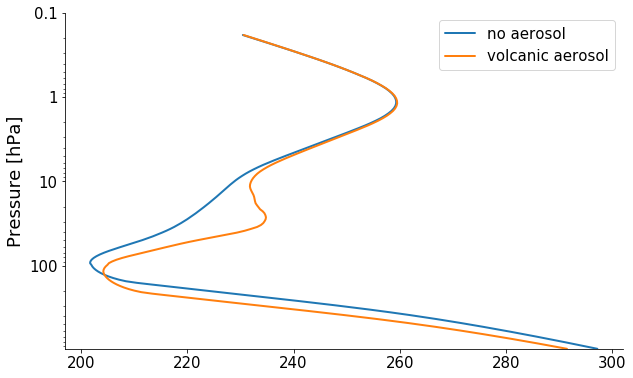

In [3]:
#Albedo changes run
plev, phlev = konrad.utils.get_pressure_grids(1000e2, 1, 201)
atmosphere = konrad.atmosphere.Atmosphere(plev)
solarConstant=480
cc=0.3
fixedRH=0.4
pressureLimitIndex=165
maxDuration='6000d'
maxDuration2='300d'
upwellingVelocity=0
year=1991
pressureMin=10
zenith_angle =42.05
run=str(9)
fixedWater=0
Albedo=0.2
convergenceFile='convergence'+run+'.nc'
convergenceFileAerosol='convergenceAerosol'+run+'.nc'
convergenceInputPath='/scratch/local1/m300733/'+convergenceFile
convergenceInputPathAerosol='/scratch/local1/m300733/'+convergenceFileAerosol
stratospheric_upwelling = konrad.upwelling.StratosphericUpwelling(w=upwellingVelocity)

# Load a standard atmosphere.
#atmosphere = konrad.atmosphere.Atmosphere.from_netcdf(
#    ncfile='data/tropical-standard.nc',
#)
atmosphere.tracegases_rcemip()  # Atmosphere composition according to RCEMIP.

# Plot the initial temperature profile (for comparison).
plt.style.use(plots.styles('typhon'))
fig, ax = plt.subplots()
#plots.profile_p_log(atmosphere['plev'], atmosphere['T'][-1, :], label='Initial state')
atmosphere.tracegases_rcemip()  # Atmosphere composition according to RCEMIP.
# Initialize the setup for the radiative-convective equilibrium simulation.
rce = konrad.RCE(
    atmosphere,
    #surface=surface,
    radiation=konrad.radiation.RRTMG(solar_constant=solarConstant,zenith_angle =zenith_angle),  # Use RRTMG radiation scheme.
    surface=konrad.surface.SurfaceHeatCapacity(albedo=Albedo),
    #surface=konrad.surface.SurfaceFixedTemperature(albedo=Albedo,   longwave_emissivity=1, height=0.0),
    convection=konrad.convection.HardAdjustment(),  # Perform a hard convective adjustment.
    #convection=konrad.convection.RelaxedAdjustment(),
    lapserate=konrad.lapserate.MoistLapseRate(),  # Adjust towards a moist adiabat.
    timestep='16h',  # Set timestep in model time.
    #humidity=konrad.humidity.FixedRH(rh_func=konrad.humidity.FixedUTH()),
    humidity=konrad.humidity.FixedRH(rh_func=konrad.humidity.HeightConstant(rh_surface=fixedRH)), 
    upwelling=stratospheric_upwelling,
    max_duration=maxDuration,  # Set maximum runtime.
    aerosol=konrad.aerosol.NoAerosol(),
    outfile=convergenceInputPath ,
    writeevery=200,
)
rce.run()  # Start the simulation.
# Plot the equilibrium temperature profile.
noAerosolAtm=atmosphere.copy()
equiNoAeroInput1=atmosphere.copy()
equiNoAeroInput2=atmosphere.copy()
plots.profile_p_log(atmosphere['plev'][0:pressureLimitIndex], atmosphere['T'][-1, 0:pressureLimitIndex], label='no aerosol')
ax = plt.gca()
ax.set_ylim([pressureMin,max(atmosphere['plev'])])
plt.gca().invert_yaxis()
ax.legend()
#plev, phlev = konrad.utils.get_pressure_grids(1000e2, 1, 201)
#atmosphere = konrad.atmosphere.Atmosphere(plev)
# Initialize the setup for the radiative-convective equilibrium simulation.
rce = konrad.RCE(
    equiNoAeroInput1,
    surface=konrad.surface.SurfaceHeatCapacity(albedo=Albedo),
    #surface=konrad.surface.SurfaceFixedTemperature(albedo=Albedo,   longwave_emissivity=1, height=0.0),
    radiation=konrad.radiation.RRTMG(solar_constant=solarConstant,zenith_angle =zenith_angle),  # Use RRTMG radiation scheme.
    convection=konrad.convection.HardAdjustment(),  # Perform a hard convective adjustment.
    #convection=konrad.convection.RelaxedAdjustment(),
    lapserate=konrad.lapserate.MoistLapseRate(),  # Adjust towards a moist adiabat.
    timestep='16h',  # Set timestep in model time.
    #humidity=konrad.humidity.FixedRH(rh_func=konrad.humidity.FixedUTH()),
    humidity=konrad.humidity.FixedRH(rh_func=konrad.humidity.HeightConstant(rh_surface=fixedRH)),
    max_duration=maxDuration2,  # Set maximum runtime.
    aerosol=konrad.aerosol.VolcanoAerosol(),
    upwelling=stratospheric_upwelling,
    outfile=convergenceInputPathAerosol,
    writeevery=1,
)
rce.run()  # Start the simulation.

# Plot the equilibrium temperature profile.
AerosolAtm=equiNoAeroInput1.copy()
plots.profile_p_log(equiNoAeroInput1['plev'][0:pressureLimitIndex], equiNoAeroInput1['T'][-1, 0:pressureLimitIndex], label='volcanic aerosol')
ax = plt.gca()
ax.set_ylim([pressureMin,max(atmosphere['plev'])])
plt.gca().invert_yaxis()
ax.legend()
if fixedWater:
    rce = konrad.RCE(
        equiNoAeroInput2,
        surface=konrad.surface.SurfaceHeatCapacity(albedo=Albedo),
        radiation=konrad.radiation.RRTMG(solar_constant=solarConstant,zenith_angle =zenith_angle),  # Use RRTMG radiation scheme.
        convection=konrad.convection.HardAdjustment(),  # Perform a hard convective adjustment.
        lapserate=konrad.lapserate.MoistLapseRate(),  # Adjust towards a moist adiabat.
        timestep='16h',  # Set timestep in model time.
        humidity=konrad.humidity.FixedVMR(),
        max_duration=maxDuration2,  # Set maximum runtime.
        aerosol=konrad.aerosol.VolcanoAerosol(),
        outfile=convergenceInputPathAerosol,
        upwelling=stratospheric_upwelling,
        writeevery=200,
    )
    rce.run()  # Start the simulation.

# Plot the equilibrium temperature profile.
    AerosolAtmFixWV=equiNoAeroInput2.copy()
    plots.profile_p_log(equiNoAeroInput2['plev'][0:pressureLimitIndex], equiNoAeroInput2['T'][-1, 0:pressureLimitIndex], label='volcanic aerosol fixed WV')

ax = plt.gca()
ax.set_ylim([pressureMin,max(atmosphere['plev'])])
plt.gca().invert_yaxis()
ax.legend()

#plev, phlev = konrad.utils.get_pressure_grids(1000e2, 1, 201)
#atmosphere = konrad.atmosphere.Atmosphere(plev)

In [4]:
celsisusConversion=0
searchEnd=100
print('surface temperature')
print('volcano '+str(max(AerosolAtm['T'][0,:searchEnd]-celsisusConversion)))
#print(str(max(AerosolAtmFixWV['T'][0,:])))
print('normal '+str(max(noAerosolAtm['T'][0,:searchEnd]-celsisusConversion)))
deltaTs=max(AerosolAtm['T'][0,:searchEnd])-max(noAerosolAtm['T'][0,:searchEnd])
print('deltaT '+str(deltaTs))
print('tropopause temperature')
print('volcano '+str(min(AerosolAtm['T'][0,:searchEnd]-celsisusConversion)))
print('normal '+str(min(noAerosolAtm['T'][0,:searchEnd]-celsisusConversion)))
deltaT=min(AerosolAtm['T'][0,:searchEnd])-min(noAerosolAtm['T'][0,:searchEnd])
print('deltaT '+str(deltaT))

surface temperature
volcano 291.45440889111154
normal 297.1791226113678
deltaT -5.724713720256261
tropopause temperature
volcano 204.17541713550105
normal 201.68040497455485
deltaT 2.495012160946203


In [6]:
import typhon.physics as ty
import scipy as sc
import numpy as np
heights = ty.pressure2height(atmosphere['plev'], atmosphere['T'][0, :])/1000

from netCDF4 import Dataset
dataNoAerosol=Dataset('/scratch/local1/m300733/convergence7.nc')
dataAerosol=Dataset('/scratch/local1/m300733/convergenceAerosol7.nc')
if year==1992:
    extSun=xr.open_dataset('/home/mpim/m300733/Documents/konrad/konrad/data/aerosolData/zonAverageExtSunbc_aeropt_cmip6_volc_lw_b16_sw_b14_1992.nc')
    extEarth=xr.open_dataset('/home/mpim/m300733/Documents/konrad/konrad/data/aerosolData/zonAverageExtEarthbc_aeropt_cmip6_volc_lw_b16_sw_b14_1992.nc')
    omegaSun=xr.open_dataset('/home/mpim/m300733/Documents/konrad/konrad/data/aerosolData/zonAverageOmegaSunbc_aeropt_cmip6_volc_lw_b16_sw_b14_1992.nc')
    gSun=xr.open_dataset('/home/mpim/m300733/Documents/konrad/konrad/data/aerosolData/zonAveragegSunbc_aeropt_cmip6_volc_lw_b16_sw_b14_1992.nc')
if year==1991:
    extSun=xr.open_dataset('/home/mpim/m300733/Documents/konrad/konrad/data/aerosolData/23dataextSun1991.nc')
    extEarth=xr.open_dataset('/home/mpim/m300733/Documents/konrad/konrad/data/aerosolData/23dataextEarth1991.nc')
    omegaSun=xr.open_dataset('/home/mpim/m300733/Documents/konrad/konrad/data/aerosolData/23dataomegaSun1991.nc')
    gSun=xr.open_dataset('/home/mpim/m300733/Documents/konrad/konrad/data/aerosolData/23datagSun1991.nc')
terrestrialBand=np.shape(extEarth.terrestrial_bands)[0] 
solarBand=np.shape(extSun.solar_bands)[0]
extEarthx=np.empty([terrestrialBand,np.shape(atmosphere['plev'])[0]])
extSunx=np.empty([solarBand,np.shape(atmosphere['plev'])[0]])
gSunx=np.empty([solarBand,np.shape(atmosphere['plev'])[0]])
omegaSunx=np.empty([solarBand,np.shape(atmosphere['plev'])[0]])
if year==1992:
    for lw_band in range(terrestrialBand):
        extEarthx[lw_band, :]=sc.interpolate.interp1d(
                        extEarth.altitude.values,
                        extEarth.ext_earth[lw_band, :, 1].values,
                        bounds_error=False,
                        fill_value=0)(heights)
    for sw_band in range(solarBand):
        extSunx[sw_band, :]=sc.interpolate.interp1d(
                        extSun.altitude.values,
                        extSun.ext_sun[sw_band, :, 1].values,
                        bounds_error=False,
                        fill_value=0)(heights)
        gSunx[sw_band, :]=sc.interpolate.interp1d(
                        gSun.altitude.values,
                        gSun.g_sun[sw_band, :, 1].values,
                        bounds_error=False,
                        fill_value=0)(heights)
        omegaSunx[sw_band, :]=sc.interpolate.interp1d(
                        omegaSun.altitude.values,
                        omegaSun.omega_sun[sw_band, :, 1].values,
                        bounds_error=False,
                        fill_value=0)(heights)
        
if year==1991:
    for lw_band in range(terrestrialBand):
        extEarthx[lw_band, :]=sc.interpolate.interp1d(
                        extEarth.altitude.values,
                        extEarth.ext_earth[8,lw_band, :].values,
                        bounds_error=False,
                        fill_value=0)(heights)
    for sw_band in range(solarBand):
        extSunx[sw_band, :]=sc.interpolate.interp1d(
                        extSun.altitude.values,
                        extSun.ext_sun[sw_band,8, :].values,
                        bounds_error=False,
                        fill_value=0)(heights)
        gSunx[sw_band, :]=sc.interpolate.interp1d(
                        gSun.altitude.values,
                        gSun.g_sun[sw_band,8, :].values,
                        bounds_error=False,
                        fill_value=0)(heights)
        omegaSunx[sw_band, :]=sc.interpolate.interp1d(
                        omegaSun.altitude.values,
                        omegaSun.omega_sun[sw_band,8, :].values,
                        bounds_error=False,
                        fill_value=0)(heights)

In [8]:
heights #from small values to large values
extSun=xr.open_dataset('/home/mpim/m300733/Documents/konrad/konrad/data/aerosolData/zonAverageExtSunbc_aeropt_cmip6_volc_lw_b16_sw_b14_1992.nc')
extSun.altitude #from small values to large values
atmosphere['plev'] #from large values to small vlaues
pgrad=np.gradient(atmosphere['plev'])
heightGrad=np.gradient(heights)
diff=pgrad-heightGrad
diff
heightGrad

array([0.2524228 , 0.25324024, 0.25486057, 0.25645144, 0.25801212,
       0.25954174, 0.26103942, 0.2625042 , 0.26393505, 0.26533088,
       0.26669053, 0.26801275, 0.26929621, 0.27053948, 0.27174102,
       0.2728992 , 0.27401224, 0.27507824, 0.27609515, 0.27706079,
       0.27797279, 0.27882845, 0.27962433, 0.28035603, 0.28101846,
       0.28160616, 0.2821135 , 0.28253473, 0.2828642 , 0.28309652,
       0.28322684, 0.28325112, 0.28316652, 0.28297163, 0.28266661,
       0.28225275, 0.28173212, 0.28110771, 0.28038361, 0.2795649 ,
       0.27865736, 0.27766725, 0.27660107, 0.2754652 , 0.27426561,
       0.27300784, 0.27169701, 0.27033784, 0.26893461, 0.26749101,
       0.26617003, 0.26537094, 0.26525827, 0.26557928, 0.26611799,
       0.26682186, 0.26766686, 0.26863929, 0.26973032, 0.27093625,
       0.27225611, 0.27364058, 0.27511396, 0.27683069, 0.27881888,
       0.28102175, 0.28343156, 0.28603905, 0.28883329, 0.29179649,
       0.29489839, 0.29810401, 0.30138384, 0.30470782, 0.30803

In [14]:
atmosphere['plev']

array([9.71559426e+04, 9.43725999e+04, 9.16428761e+04, 8.89667533e+04,
       8.63441690e+04, 8.37750174e+04, 8.12591510e+04, 7.87963816e+04,
       7.63864821e+04, 7.40291879e+04, 7.17241981e+04, 6.94711772e+04,
       6.72697565e+04, 6.51195355e+04, 6.30200834e+04, 6.09709403e+04,
       5.89716193e+04, 5.70216073e+04, 5.51203665e+04, 5.32673362e+04,
       5.14619338e+04, 4.97035565e+04, 4.79915824e+04, 4.63253720e+04,
       4.47042694e+04, 4.31276037e+04, 4.15946903e+04, 4.01048322e+04,
       3.86573208e+04, 3.72514379e+04, 3.58864560e+04, 3.45616400e+04,
       3.32762481e+04, 3.20295329e+04, 3.08207426e+04, 2.96491216e+04,
       2.85139120e+04, 2.74143542e+04, 2.63496879e+04, 2.53191529e+04,
       2.43219902e+04, 2.33574424e+04, 2.24247549e+04, 2.15231763e+04,
       2.06519594e+04, 1.98103616e+04, 1.89976457e+04, 1.82130805e+04,
       1.74559411e+04, 1.67255101e+04, 1.60210773e+04, 1.53419407e+04,
       1.46874068e+04, 1.40567911e+04, 1.34494182e+04, 1.28646224e+04,
      

/home/mpim/m300733/anaconda3/lib/python3.7/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


/home/mpim/m300733/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:2575: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  self.apply_aspect()
/home/mpim/m300733/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:4371: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  self.apply_aspect()
/home/mpim/m300733/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:848: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  self.apply_aspect()


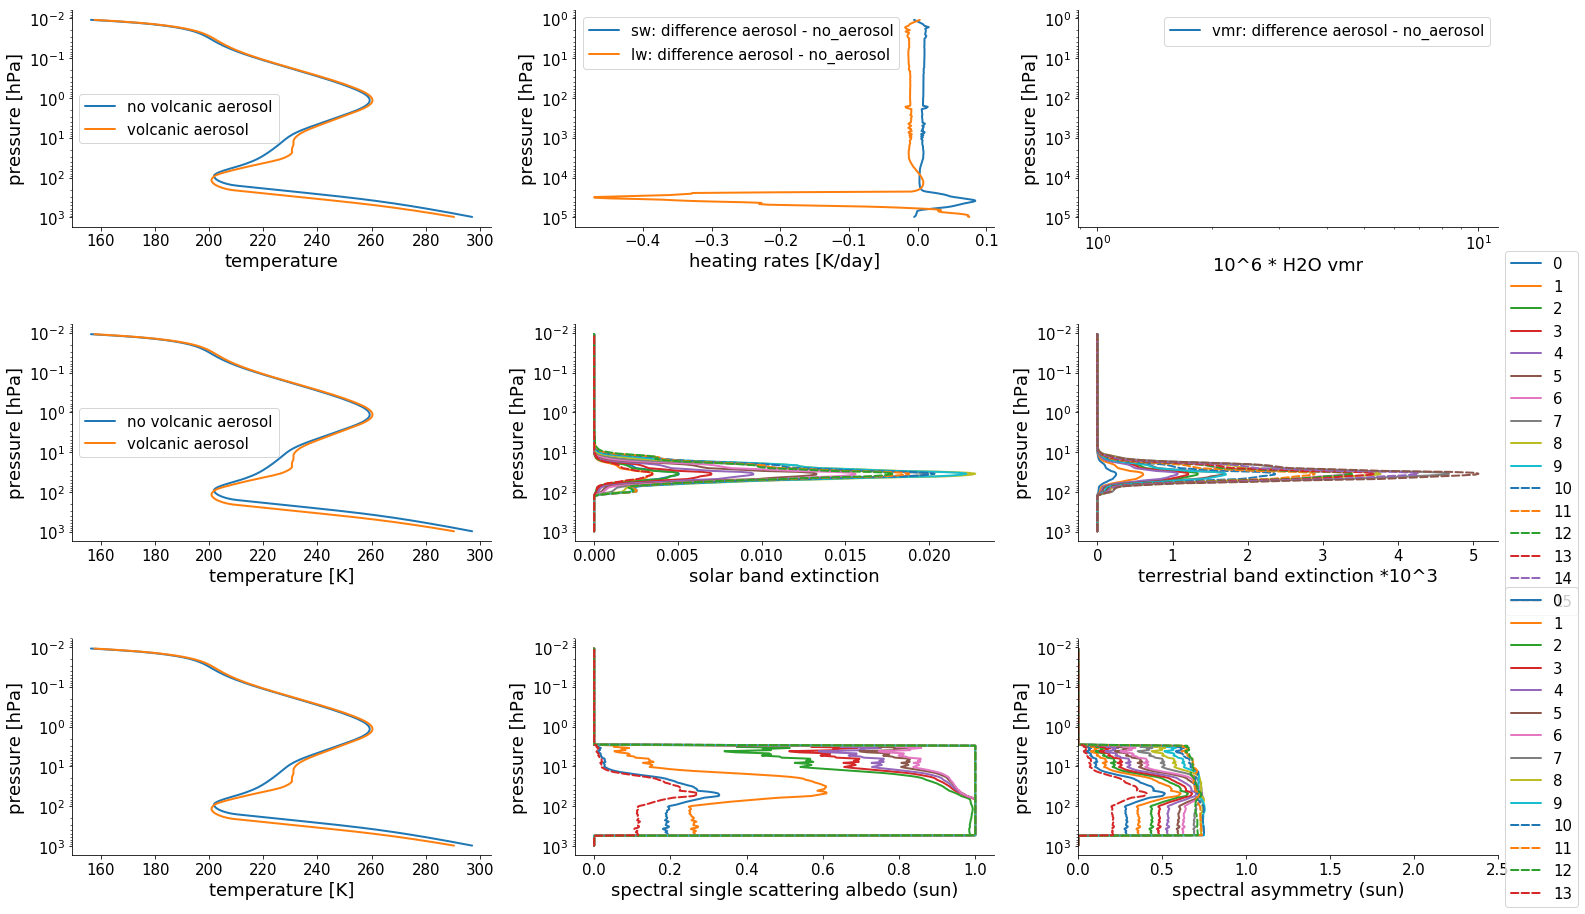

In [6]:
fig,ax=plt.subplots(3,3)
dataTimestep=31

ax[0,0].plot(noAerosolAtm['T'][-1, :], noAerosolAtm['plev'][:]/100, label='no volcanic aerosol')
ax[0,0].plot(AerosolAtm['T'][-1, :], AerosolAtm['plev'][:]/100, label='volcanic aerosol')
plt.gca().invert_yaxis()
ax[0,1].invert_yaxis()
ax[0,0].invert_yaxis()
ax[0,1].plot(-dataNoAerosol['radiation']['sw_htngrt'][dataNoAerosol['radiation']['sw_htngrt'].shape[0]-dataTimestep,:]+dataAerosol['radiation']['sw_htngrt'][dataAerosol['radiation']['sw_htngrt'].shape[0]-dataTimestep,:],dataNoAerosol['plev'][:], label='sw: difference aerosol - no_aerosol')
ax[0,1].plot(-dataNoAerosol['radiation']['lw_htngrt'][dataNoAerosol['radiation']['lw_htngrt'].shape[0]-dataTimestep,:]+dataAerosol['radiation']['lw_htngrt'][dataAerosol['radiation']['lw_htngrt'].shape[0]-dataTimestep,:],dataAerosol['plev'][:], label='lw: difference aerosol - no_aerosol')
ax[0,2].plot((-noAerosolAtm['H2O'][0,:]+AerosolAtm['H2O'][0,:])*10**6,dataAerosol['plev'], label='vmr: difference aerosol - no_aerosol')
#ax = plt.gca()
ax[1,0].plot(noAerosolAtm['T'][-1, :], noAerosolAtm['plev'][:]/100, label='no volcanic aerosol')
ax[1,0].plot(AerosolAtm['T'][-1, :], AerosolAtm['plev'][:]/100, label='volcanic aerosol')
for i in range(14):
    ax[1,1].plot(extSunx[i,:],AerosolAtm['plev'][:]/100 , label=str(i))
for i in range(16):
    ax[1,2].plot(extEarthx[i,:]*10**3, AerosolAtm['plev'][:]/100, label=str(i))
ax[2,0].plot(noAerosolAtm['T'][-1, :], noAerosolAtm['plev'][:]/100, label='no volcanic aerosol')
ax[2,0].plot(AerosolAtm['T'][-1, :], AerosolAtm['plev'][:]/100, label='volcanic aerosol')
for i in range(14):
    ax[2,1].plot(omegaSunx[i,:], AerosolAtm['plev'][:]/100 , label=str(i))
    ax[2,2].plot(gSunx[i,:],AerosolAtm['plev'][:]/100 , label=str(i))
#ax.set_ylim([pressureMin,max(atmosphere['plev'])])
#plt.gca().invert_yaxis()
ax[0,0].set_yscale('log')
ax[0,1].set_yscale('log')
ax[0,2].set_yscale('log')
ax[0,2].set_xscale('log')
ax[0,2].set_xscale('log')
ax[1,0].set_yscale('log')
ax[1,1].set_yscale('log')
ax[1,2].set_yscale('log')
ax[2,0].set_yscale('log')
ax[2,1].set_yscale('log')
ax[2,2].set_yscale('log')
ax[0,2].invert_yaxis()
ax[1,0].invert_yaxis()
ax[1,1].invert_yaxis()
ax[1,2].invert_yaxis()
ax[2,0].invert_yaxis()
ax[2,2].invert_yaxis()
ax[2,1].invert_yaxis()

plt.gca().invert_yaxis()
#ax.plt(axis='equal')
ax[0,0].set_xlabel('temperature')
ax[0,0].set_ylabel('pressure [hPa]')
plt.gca().set_aspect('equal', adjustable='box')
ax[0,1].set_xlabel('heating rates [K/day]')
ax[0,1].set_ylabel('pressure [hPa]')
ax[0,2].set_xlabel('10^6 * H2O vmr')
ax[0,2].set_ylabel('pressure [hPa]')
ax[1,0].set_xlabel('temperature [K]')
ax[1,0].set_ylabel('pressure [hPa]')
ax[1,1].set_xlabel('solar band extinction')
ax[1,1].set_ylabel('pressure [hPa]')
ax[1,2].set_xlabel('terrestrial band extinction *10^3')
ax[1,2].set_ylabel('pressure [hPa]')
ax[2,0].set_xlabel('temperature [K]')
ax[2,0].set_ylabel('pressure [hPa]')
ax[2,1].set_xlabel('spectral single scattering albedo (sun)')
ax[2,1].set_ylabel('pressure [hPa]')
ax[2,2].set_xlabel('spectral asymmetry (sun)')
ax[2,2].set_ylabel('pressure [hPa]')
ax[2,2].set_xlim([0,2.5])
plt.subplots_adjust(bottom=0, left=.01, right=1.99, top=1.90, hspace=.45)
ax[0,0].legend()
ax[0,1].legend()
ax[0,2].legend()
ax[1,0].legend()

#ax[1,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1,2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
#ax[2,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[2,2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

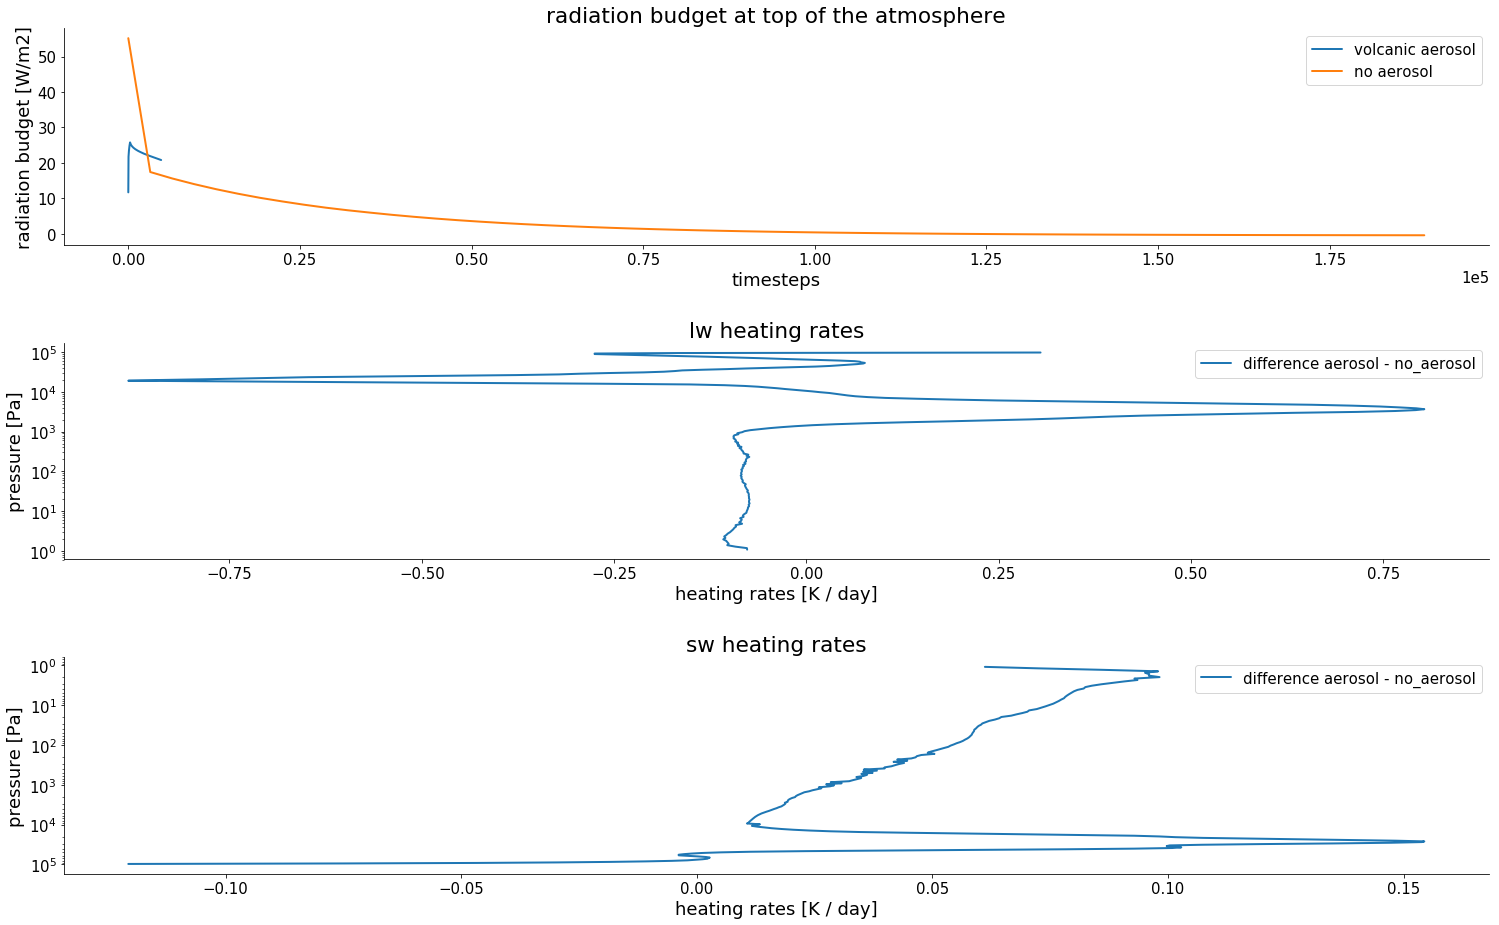

In [41]:
from netCDF4 import Dataset
dataNoAerosol=Dataset('/scratch/local1/m300733/convergence9.nc')
dataAerosol=Dataset('/scratch/local1/m300733/convergenceAerosol9.nc')
fig,ax=plt.subplots(3,1)
#plt.suptitle('run without aerosol',fontsize=16)
ax[0].plot(dataAerosol['time'],dataAerosol['radiation']['toa'],label='volcanic aerosol')
ax[0].plot(dataNoAerosol['time'],dataNoAerosol['radiation']['toa'],label='no aerosol')

ax[1].plot(-dataNoAerosol['radiation']['lw_htngrt'][5,:]+dataAerosol['radiation']['lw_htngrt'][5,:],dataAerosol['plev'],label='difference aerosol - no_aerosol')
#ax[1].plot(dataNoAerosol['radiation']['lw_htngrt'][5,:],dataNoAerosol['plev'],label='no aerosol')
#ax[2].plot(dataAerosol['radiation']['sw_htngrt'][5,:],dataAerosol['plev'],label='volcanic aerosol')
ax[2].plot(-dataNoAerosol['radiation']['sw_htngrt'][5,:]+dataAerosol['radiation']['sw_htngrt'][5,:],dataNoAerosol['plev'],label='difference aerosol - no_aerosol')

ax[0].set_title('radiation budget at top of the atmosphere')
ax[0].set_xlabel('timesteps')
ax[0].set_ylabel('radiation budget [W/m2]')
 
plt.gca().invert_yaxis()
ax[1].set_yscale('log')
#ax[1].invert_yaxis()
ax[1].set_title('lw heating rates')
ax[1].set_ylabel('pressure [Pa]')
ax[1].set_xlabel('heating rates [K / day]')

#ax.set_ylim([pressureMin,max(atmosphere['plev'])])
ax[2].set_yscale('log')
#ax[2].invert_yaxis()
ax[2].set_title('sw heating rates')
ax[2].set_xlabel('heating rates [K / day]')
ax[2].set_ylabel('pressure [Pa]')

plt.subplots_adjust(bottom=0, left=.01, right=1.99, top=1.90, hspace=.45)
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.show()

In [2]:
extSun=xr.open_dataset('/home/mpim/m300733/Documents/konrad/konrad/data/aerosolData/zonAverageExtSunbc_aeropt_cmip6_volc_lw_b16_sw_b14_1992.nc')
extEarth=xr.open_dataset('/home/mpim/m300733/Documents/konrad/konrad/data/aerosolData/zonAverageExtEarthbc_aeropt_cmip6_volc_lw_b16_sw_b14_1992.nc')
omegaSun=xr.open_dataset('/home/mpim/m300733/Documents/konrad/konrad/data/aerosolData/zonAverageOmegaSunbc_aeropt_cmip6_volc_lw_b16_sw_b14_1992.nc')
gSun=xr.open_dataset('/home/mpim/m300733/Documents/konrad/konrad/data/aerosolData/zonAveragegSunbc_aeropt_cmip6_volc_lw_b16_sw_b14_1992.nc')

In [4]:
plev, phlev = konrad.utils.get_pressure_grids(1000e2, 1, 201)
#another_cloud=konrad.cloud.ClearSky(numlevels=200)
Albedo=0.2
another_cloud = konrad.cloud.PhysicalCloud(numlevels=200, cloud_fraction=0, mass_ice=0, mass_water=0,
ice_particle_size=0, droplet_radius=0)
Atmosphere = konrad.atmosphere.Atmosphere(plev)
Surface=konrad.surface.SurfaceHeatCapacity(albedo=Albedo,longwave_emissivity=1),
rt = konrad.radiation.RRTMG(mcica=True, cloud_optical_properties='liquid_and_ice_clouds')
rt.calc_radiation(atmosphere=Atmosphere,surface=Surface, cloud=another_cloud, aerosol=konrad.aerosol.VolcanoAerosol())

TypeError: __init__() got an unexpected keyword argument 'cloud_optical_properties'

In [8]:
import konrad
plev, phlev = konrad.utils.get_pressure_grids(1000e2, 1, 201)
#another_cloud=konrad.cloud.ClearSky(numlevels=200)
Albedo=0.2
another_cloud = konrad.cloud.PhysicalCloud(numlevels=200, cloud_fraction=0, mass_ice=0, mass_water=0,
ice_particle_size=0, droplet_radius=0)
Atmosphere = konrad.atmosphere.Atmosphere(plev)
Surface=konrad.surface.SurfaceHeatCapacity(albedo=Albedo, temperature=288., longwave_emissivity=1,height=0.),
rt = konrad.radiation.RRTMG(mcica=True)#, cloud_optical_properties='liquid_and_ice_clouds')
rt.calc_radiation(atmosphere=Atmosphere,surface=Surface, cloud=another_cloud, aerosol=konrad.aerosol.VolcanoAerosol())

AttributeError: 'tuple' object has no attribute 'longwave_emissivity'